In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
import seaborn as sns
sns.set_style("dark")

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

from warnings import filterwarnings
filterwarnings('ignore')

%pylab inline
data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1)

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('data_cleaned.csv')
data = data[[i for i in data.columns if 'Unnamed' not in i]]

# Use only good data

# Users could enter any number for age, so let's remove the jokers
data = data[data['age'] < 71]
data.replace(-1, np.nan, inplace=True)
data = data.dropna()

# Simplify genders down to two, for convenience
data = data[(data['gender'] < 3) & (data['gender'] > 0)]
data['gender'] = np.where(data['gender'] == 1, 'man', 'woman')

data['reliable'] = np.where(
    np.abs(data['I have frequent mood swings.'] - data['I change my mood a lot.']) > 2, 0, 1)

data = data[data.reliable == 1]
del data['reliable']

# Remove demographics
data = data.drop(['age', 'gender', 'country'], axis=1)

data.shape

(19011, 50)

# Factor analysis

In [3]:
from sklearn.decomposition import FactorAnalysis

def get_factor(remaining=data.columns, threshold=0.65):

    fa = FactorAnalysis(n_components=1, random_state=200).fit(data[remaining])

    factor = pd.DataFrame(fa.components_, columns=data[remaining].columns).T

    factor.columns = [i+1 for i in factor.columns]
    factor['absol'] = abs(factor[1])
    
    remaining = factor[np.abs(factor[1]) < threshold].index
    factor = factor[factor.absol >= threshold]
    
    factor = pd.DataFrame(factor.sort_values('absol', ascending=False)[1])

    return factor, remaining

factor, remaining = get_factor(threshold=.72)

# Extraversion
factor

,1
I talk to a lot of different people at parties.,-0.990938
I start conversations.,-0.919648
I feel comfortable around people.,-0.919154
I am quiet around strangers.,0.810207
I keep in the background.,0.777479
I don't talk a lot.,0.759983
I have little to say.,0.724442


I'm still experimenting with the methodology, but if we're measuring psychological constructs, it's also important for the intercorrelations within each factor's items to be high (ideally 0.70 or greater).

In [4]:
def intercorrelations(factor=factor):
    factor_questions = factor.index
    intercorrelations = {}

    for i in factor_questions:
        corrs = abs(data[factor_questions].drop(i, axis=1).corrwith(data[i]))
        intercorrelations[i] = corrs.mean()

    return pd.DataFrame([intercorrelations]).T.sort_values(0, ascending=False)
    
intercorrelations()

,0
I start conversations.,0.552253
I talk to a lot of different people at parties.,0.525610
I don't talk a lot.,0.507406
I keep in the background.,0.507092
I feel comfortable around people.,0.498785
I am quiet around strangers.,0.494405
I have little to say.,0.458996


We can also look at the items that are most highly correlated with our strongest factor loading...

In [5]:
corrs = absolute_correlations(factor.index[0], df=data)
corrs.head(10)

,correlation
I talk to a lot of different people at parties.,1.000000
I start conversations.,0.634175
I am the life of the party.,0.591438
I feel comfortable around people.,0.582116
I am quiet around strangers.,-0.538342
I keep in the background.,-0.509595
I don't talk a lot.,-0.481347
I don't mind being the center of attention.,0.436464
I have little to say.,-0.408088
I am interested in people.,0.359238


Lots of overlap. Let's zero in on it.

In [6]:
def overlap(factor=factor, corrs=corrs):
    factor_items = set(factor.index)
    corr_items = set(corrs.head(10).index)

    return factor_items.intersection(corr_items)

overlap()

{'I am quiet around strangers.',
 "I don't talk a lot.",
 'I feel comfortable around people.',
 'I have little to say.',
 'I keep in the background.',
 'I start conversations.',
 'I talk to a lot of different people at parties.'}

We should have very high confidence that these are all measuring the same phenomenon (in this case, extraversion).

Let's create a new feature using this factor!

In [7]:
fa = FactorAnalysis(n_components=1).fit(data.values)
fa1 = fa.transform(data)

from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler().fit(fa1)
fa1 = mms.transform(fa1)
data['factor_1'] = fa1

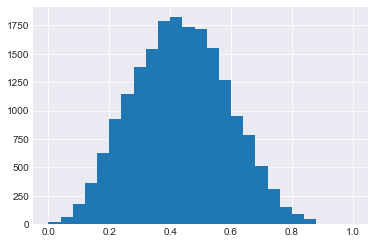

In [15]:
data['factor_1'].hist(bins=25)

# Factor 2

In [7]:
factor, remaining = get_factor(threshold=.69, remaining=remaining)

# Neuroticism
factor

,1
I have frequent mood swings.,1.043084
I change my mood a lot.,0.973750
I get upset easily.,0.934647
I get irritated easily.,0.894693
I often feel blue.,0.864622
I get stressed out easily.,0.815052
I am easily disturbed.,0.695949


In [8]:
intercorrelations(factor)

,0
I have frequent mood swings.,0.552610
I change my mood a lot.,0.534313
I get upset easily.,0.528063
I get irritated easily.,0.503807
I get stressed out easily.,0.453549
I often feel blue.,0.446918
I am easily disturbed.,0.402935


In [9]:
corrs = absolute_correlations(factor.index[0], df=data)
corrs.head(10)

,correlation
I have frequent mood swings.,1.000000
I change my mood a lot.,0.827954
I get upset easily.,0.553751
I often feel blue.,0.550588
I get irritated easily.,0.542046
I get stressed out easily.,0.441301
I am easily disturbed.,0.400020
I worry about things.,0.366616
I make a mess of things.,0.354297
I am relaxed most of the time.,-0.334318


In [10]:
# Definitely all measuring neuroticism
overlap(factor, corrs)

{'I am easily disturbed.',
 'I change my mood a lot.',
 'I get irritated easily.',
 'I get stressed out easily.',
 'I get upset easily.',
 'I have frequent mood swings.',
 'I often feel blue.'}

In [11]:
factor, remaining = get_factor(threshold=.45, remaining=remaining)

# Agreeableness
factor

,1
I am not really interested in others.,0.745484
I feel others' emotions.,-0.743416
I sympathize with others' feelings.,-0.737271
I am not interested in other people's problems.,0.721981
I am interested in people.,-0.651065
I take time out for others.,-0.612432
I have a soft heart.,-0.574142
I feel little concern for others.,0.566352
I make people feel at ease.,-0.533410
I insult people.,0.451584


In [12]:
intercorrelations(factor)

,0
I sympathize with others' feelings.,0.438229
I feel others' emotions.,0.406503
I am not really interested in others.,0.396063
I am not interested in other people's problems.,0.390741
I take time out for others.,0.357330
I am interested in people.,0.346550
I have a soft heart.,0.330095
I make people feel at ease.,0.275829
I feel little concern for others.,0.259143
I insult people.,0.230967


In [13]:
corrs = absolute_correlations(factor.index[0], df=data)
corrs.head(10)

,correlation
I am not really interested in others.,1.000000
I am interested in people.,-0.576172
I am not interested in other people's problems.,0.566997
I sympathize with others' feelings.,-0.442638
I feel others' emotions.,-0.400865
I feel comfortable around people.,-0.395960
I take time out for others.,-0.393673
I start conversations.,-0.355640
I talk to a lot of different people at parties.,-0.353660
I feel little concern for others.,0.351497


In [14]:
overlap(factor, corrs)

{'I am interested in people.',
 "I am not interested in other people's problems.",
 'I am not really interested in others.',
 'I feel little concern for others.',
 "I feel others' emotions.",
 "I sympathize with others' feelings.",
 'I take time out for others.'}

In [15]:
factor, remaining = get_factor(threshold=.43, remaining=remaining)

# Conscientiousness
factor

,1
I often forget to put things back in their proper place.,0.790038
I make a mess of things.,0.744097
I get chores done right away.,-0.733860
I follow a schedule.,-0.704672
I am always prepared.,-0.680491
I leave my belongings around.,0.641353
I shirk my duties.,0.592405
I like order.,-0.545949
I am exacting in my work.,-0.506206
I pay attention to details.,-0.434435


In [16]:
intercorrelations(factor)

,0
I get chores done right away.,0.340567
I often forget to put things back in their proper place.,0.337658
I follow a schedule.,0.334820
I am always prepared.,0.334029
I make a mess of things.,0.329915
I leave my belongings around.,0.289719
I shirk my duties.,0.287594
I like order.,0.286262
I am exacting in my work.,0.264007
I pay attention to details.,0.229430


In [17]:
corrs = absolute_correlations(factor.index[0], df=data)
corrs.head(10)

,correlation
I often forget to put things back in their proper place.,1.000000
I leave my belongings around.,0.514156
I make a mess of things.,0.465215
I get chores done right away.,-0.392419
I follow a schedule.,-0.323867
I am always prepared.,-0.313593
I shirk my duties.,0.311953
I like order.,-0.305835
I pay attention to details.,-0.212707
I am exacting in my work.,-0.199176


In [18]:
overlap(factor, corrs)

{'I am always prepared.',
 'I am exacting in my work.',
 'I follow a schedule.',
 'I get chores done right away.',
 'I leave my belongings around.',
 'I like order.',
 'I make a mess of things.',
 'I often forget to put things back in their proper place.',
 'I pay attention to details.',
 'I shirk my duties.'}